In [1]:
import pandas as pd

# df = pd.read_parquet("data/eurosat_rgb/initial_samples.parquet")
df = pd.read_parquet("active_labeled.parquet")
df


,filename,filepath,label
0,AnnualCrop_2216.tif,data/eurosat_rgb/0/AnnualCrop_2216.jpg,Annual Crop
1,AnnualCrop_1331.tif,data/eurosat_rgb/0/AnnualCrop_1331.jpg,Annual Crop
2,AnnualCrop_631.tif,data/eurosat_rgb/0/AnnualCrop_631.jpg,Annual Crop
3,AnnualCrop_2904.tif,data/eurosat_rgb/0/AnnualCrop_2904.jpg,Annual Crop
4,AnnualCrop_1963.tif,data/eurosat_rgb/0/AnnualCrop_1963.jpg,Annual Crop
...,...,...,...
515,None,data/eurosat_rgb/2/HerbaceousVegetation_1192.jpg,Herbaceous Vegetation
516,None,data/eurosat_rgb/2/HerbaceousVegetation_611.jpg,Herbaceous Vegetation
517,None,data/eurosat_rgb/2/HerbaceousVegetation_2926.jpg,Herbaceous Vegetation
518,None,data/eurosat_rgb/2/HerbaceousVegetation_2591.jpg,Herbaceous Vegetation


In [2]:
df["label"].value_counts()

label
Herbaceous Vegetation    90
Permanent Crop           76
Highway                  68
River                    67
Pasture                  57
Annual Crop              52
Industrial Buildings     33
SeaLake                  30
Residential Buildings    26
Forest                   21
Name: count, dtype: int64

In [3]:
from active_vision import ActiveLearner
from fastai.vision.models.all import resnet18
from fastai.vision.all import aug_transforms

al = ActiveLearner(resnet18)

2025-01-22 12:31:02.936 | INFO     | active_vision.core:load_model:39 - Loading fastai model resnet18


In [4]:
al.load_dataset(df, filepath_col="filepath", label_col="label", 
                batch_size=16,
                image_size=64,
                batch_tfms=aug_transforms(size=64))

2025-01-22 12:31:02.946 | INFO     | active_vision.core:load_dataset:57 - Loading dataset from filepath and label
2025-01-22 12:31:02.946 | INFO     | active_vision.core:load_dataset:60 - Creating dataloaders
2025-01-22 12:31:03.320 | INFO     | active_vision.core:load_dataset:82 - Creating learner
2025-01-22 12:31:03.450 | INFO     | active_vision.core:load_dataset:89 - Done. Ready to train.


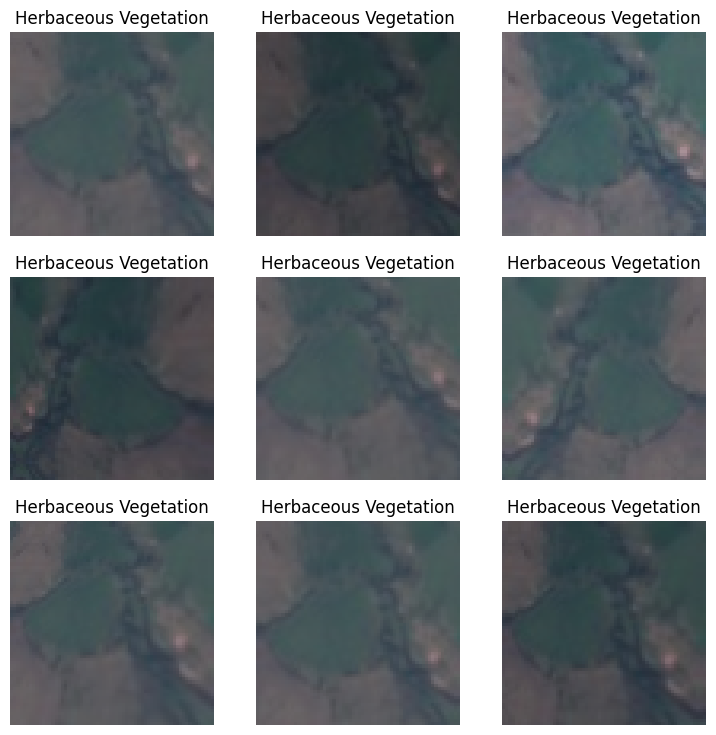

In [5]:
al.show_batch(unique=True)

In [6]:
# al.train_set

In [7]:
# al.lr_find()

2025-01-22 12:31:03.852 | INFO     | active_vision.core:train:125 - Training head for 3 epochs
2025-01-22 12:31:03.853 | INFO     | active_vision.core:train:126 - Training model end-to-end for 10 epochs
2025-01-22 12:31:03.853 | INFO     | active_vision.core:train:127 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,3.361940,2.154070,0.269231,00:01
1,2.729013,2.104696,0.423077,00:01
2,2.436130,2.506611,0.442308,00:01


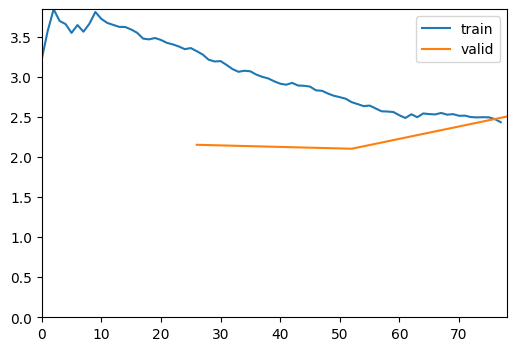

epoch,train_loss,valid_loss,accuracy,time
0,1.714251,1.940934,0.471154,00:01
1,1.549290,1.920844,0.538462,00:01
2,1.405416,1.857621,0.538462,00:01
3,1.199028,1.693566,0.615385,00:01
4,1.147045,1.689676,0.605769,00:01
5,0.970636,1.421968,0.625000,00:01
6,0.833274,1.295943,0.653846,00:01
7,0.689009,1.339166,0.605769,00:01
8,0.627529,1.347079,0.615385,00:01
9,0.551578,1.409711,0.605769,00:01


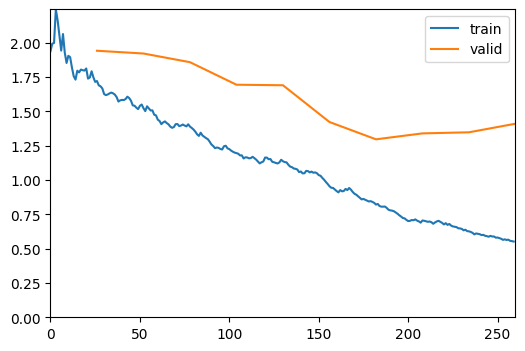

In [8]:
al.train(epochs=10, lr=5e-3, head_tuning_epochs=3)

## Evaluate the model on a *labeled* evaluation set

In [9]:
evaluation_df = pd.read_parquet("data/eurosat_rgb/evaluation_samples.parquet")
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")


2025-01-22 12:31:28.396 | INFO     | active_vision.core:evaluate:172 - Accuracy: 86.13%


0.8612962962962963

## Get the predictions from an *unlabeled* set

In [10]:
df = pd.read_parquet("data/eurosat_rgb/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

16100

In [11]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-01-22 12:31:28.424 | INFO     | active_vision.core:predict:136 - Running inference on 16100 samples


,filepath,pred_label,pred_conf,pred_raw
0,data/eurosat_rgb/0/AnnualCrop_1.jpg,Annual Crop,0.967321,"[0.9673207998275757, 0.0002652374096214771, 0.0006622640648856759, 7.00411110301502e-05, 0.00021302020468283445, 0.0003346372686792165, 0.030792297795414925, 0.0001447008253308013, 9.278939251089469e-05, 0.00010422409104648978]"
1,data/eurosat_rgb/0/AnnualCrop_10.jpg,Annual Crop,0.998683,"[0.9986826777458191, 1.454612061024818e-06, 1.0978349251899999e-07, 2.440415016735642e-07, 2.256678044432192e-08, 1.980763227038551e-05, 3.36131193989786e-08, 8.451598318970355e-07, 0.0012545157223939896, 4.040518251713365e-05]"
2,data/eurosat_rgb/0/AnnualCrop_100.jpg,Annual Crop,0.930409,"[0.9304090738296509, 4.749227809952572e-05, 1.4038690096640494e-05, 0.0640614703297615, 7.754058606224135e-05, 0.0022495316807180643, 0.0014435689663514495, 0.00035784445935860276, 0.0011084452271461487, 0.00023104174761101604]"
3,data/eurosat_rgb/0/AnnualCrop_1000.jpg,Annual Crop,0.994926,"[0.9949260950088501, 0.00010931272845482454, 0.00023334396246355027, 0.003723923349753022, 0.00026831511058844626, 0.00031684787245467305, 0.00011355629976605996, 0.0002230936661362648, 5.4484906286234036e-05, 3.116606967523694e-05]"
4,data/eurosat_rgb/0/AnnualCrop_1001.jpg,Annual Crop,0.988715,"[0.9887153506278992, 5.752436845796183e-05, 0.00048779926146380603, 0.0028167017735540867, 0.0020327605307102203, 0.00029471173183992505, 0.004999295808374882, 0.00013611999747809023, 2.450048668833915e-05, 0.0004351305542513728]"
...,...,...,...,...
16095,data/eurosat_rgb/9/SeaLake_993.jpg,SeaLake,0.999845,"[6.102318729972467e-05, 4.07893858209718e-05, 6.628496862504107e-07, 3.2120776722877054e-06, 9.93747016764246e-06, 3.124970930912241e-07, 7.041179372890838e-08, 3.7797763070557266e-05, 1.2677331824306748e-06, 0.9998449087142944]"
16096,data/eurosat_rgb/9/SeaLake_994.jpg,SeaLake,0.998277,"[0.0016483592335134745, 4.6035398554522544e-05, 1.308281696310587e-07, 6.735461965945433e-07, 1.8130955368178547e-06, 4.97612745675724e-07, 9.062201655751778e-08, 2.4514964025001973e-05, 1.3213175407145172e-06, 0.9982765913009644]"
16097,data/eurosat_rgb/9/SeaLake_995.jpg,SeaLake,0.999903,"[6.540823960676789e-05, 9.290460184274707e-06, 4.8775671501744e-08, 3.851519352338073e-07, 1.1600019433899433e-06, 3.7986531253864086e-08, 1.2477792132870036e-08, 2.0026460333610885e-05, 2.873408391224075e-07, 0.9999033212661743]"
16098,data/eurosat_rgb/9/SeaLake_996.jpg,SeaLake,0.998702,"[0.0002982705773320049, 0.0006874313694424927, 2.128927462763386e-06, 2.240163303213194e-05, 4.1566639993106946e-05, 5.630929081235081e-06, 6.595109312002023e-07, 0.0002312747819814831, 8.338243787875399e-06, 0.9987022876739502]"


In [12]:
uncertain_df = al.sample_uncertain(pred_df, num_samples=30)
uncertain_df

2025-01-22 12:31:30.749 | INFO     | active_vision.core:sample_uncertain:194 - Getting top 30 low confidence samples


,filepath,pred_label,pred_conf,pred_raw,uncertainty_score
9182,data/eurosat_rgb/5/Pasture_531.jpg,Industrial Buildings,0.199940,"[0.10977204889059067, 0.19369348883628845, 0.11594238877296448, 0.11779697984457016, 0.19993959367275238, 0.11068703979253769, 0.06570810824632645, 0.025731662288308144, 0.04826122894883156, 0.012467347085475922]",0.800060
306,data/eurosat_rgb/0/AnnualCrop_1452.jpg,Pasture,0.227985,"[0.17008718848228455, 0.10774509608745575, 0.21925105154514313, 0.07564175873994827, 0.03247756138443947, 0.22798502445220947, 0.12108193337917328, 0.01124039851129055, 0.033738359808921814, 0.0007515904144383967]",0.772015
13596,data/eurosat_rgb/8/River_2207.jpg,Annual Crop,0.251785,"[0.2517845928668976, 0.16961894929409027, 0.007276344578713179, 0.22702458500862122, 0.05212385579943657, 0.0019280393607914448, 0.004294284153729677, 0.0776856541633606, 0.18349137902259827, 0.02477230504155159]",0.748215
4402,data/eurosat_rgb/2/HerbaceousVegetation_2286.jpg,Permanent Crop,0.252361,"[0.005181622225791216, 0.05299386754631996, 0.24893417954444885, 0.03571383282542229, 0.15900668501853943, 0.06939707696437836, 0.2523609399795532, 0.12251140177249908, 0.0035266648046672344, 0.05037380009889603]",0.747639
10301,data/eurosat_rgb/6/PermanentCrop_2198.jpg,Highway,0.261028,"[0.24235618114471436, 0.0058805979788303375, 0.010975679382681847, 0.26102787256240845, 0.15894106030464172, 0.004235635977238417, 0.21200701594352722, 0.028622066602110863, 0.07469450682401657, 0.0012594093568623066]",0.738972
9857,data/eurosat_rgb/6/PermanentCrop_1520.jpg,Permanent Crop,0.263859,"[0.0030390569008886814, 0.15801960229873657, 0.2478724867105484, 0.0077151651494205, 0.025570262223482132, 0.06720439344644547, 0.2638588845729828, 0.14844569563865662, 0.0012994457501918077, 0.076975017786026]",0.736141
10408,data/eurosat_rgb/6/PermanentCrop_2362.jpg,Permanent Crop,0.264053,"[0.023909911513328552, 0.02697467803955078, 0.24183553457260132, 0.25368908047676086, 0.05229900777339935, 0.010318733751773834, 0.2640526592731476, 0.11751644313335419, 0.0021650372073054314, 0.007238897029310465]",0.735947
10544,data/eurosat_rgb/6/PermanentCrop_320.jpg,River,0.264498,"[0.0004759324947372079, 0.0010704376036301255, 0.255859911441803, 0.16584213078022003, 0.0021729276049882174, 0.0009938677540048957, 0.25189316272735596, 0.053788505494594574, 0.26449787616729736, 0.0034051674883812666]",0.735502
14148,data/eurosat_rgb/8/River_785.jpg,Highway,0.276914,"[0.21650490164756775, 0.007692231331020594, 0.0002312667202204466, 0.27691400051116943, 0.17670616507530212, 0.0007838947931304574, 0.0004626315785571933, 0.02321278303861618, 0.27583441138267517, 0.021657830104231834]",0.723086
4272,data/eurosat_rgb/2/HerbaceousVegetation_2080.jpg,Permanent Crop,0.279818,"[0.008318767882883549, 0.2532886564731598, 0.2045193463563919, 0.00930748414248228, 0.006587116979062557, 0.16578665375709534, 0.27981793880462646, 0.015987936407327652, 0.0036555572878569365, 0.052730493247509]",0.720182


## Label the uncertain samples

In [ ]:
al.label(uncertain_df, output_filename="uncertain")

In [ ]:
labeled_df = pd.read_parquet("uncertain.parquet")

labeled_df


In [ ]:
al.add_to_train_set(labeled_df, output_filename="active_labeled")